# Stellar Classification Dataset | Final Project

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

df = pd.read_csv("../../data/star_classification.csv")

df.columns

Index(['obj_ID', 'alpha', 'delta', 'u', 'g', 'r', 'i', 'z', 'run_ID',
       'rerun_ID', 'cam_col', 'field_ID', 'spec_obj_ID', 'class', 'redshift',
       'plate', 'MJD', 'fiber_ID'],
      dtype='object')

In [3]:
df.head(10)

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842
5,1.237680e+18,340.995121,20.589476,23.48827,23.33776,21.32195,20.25615,19.54544,8102,301,3,110,5.658977e+18,QSO,1.424659,5026,55855,741
6,1.237679e+18,23.234926,11.418188,21.46973,21.17624,20.92829,20.60826,20.42573,7773,301,2,462,1.246262e+19,QSO,0.586455,11069,58456,113
7,1.237679e+18,5.433176,12.065186,22.24979,22.02172,20.34126,19.48794,18.84999,7773,301,2,346,6.961443e+18,GALAXY,0.477009,6183,56210,15
8,1.237661e+18,200.290475,47.199402,24.40286,22.35669,20.61032,19.46490,18.95852,3716,301,5,108,7.459285e+18,GALAXY,0.660012,6625,56386,719
9,1.237671e+18,39.149691,28.102842,21.74669,20.03493,19.17553,18.81823,18.65422,5934,301,4,122,2.751763e+18,STAR,-0.000008,2444,54082,232


## Sin Columnas Categoricas
#### si "class" fuera insertada como categorica y se le aplicara OHE le haria ruido al modelo
## ¿Por que?
#### Esta columna esta altamente relacionada con y-Objetivo por lo tanto si se le puede dar un peso:

In [4]:
df.groupby("class")["redshift"].mean().round(1)

class
GALAXY    0.4
QSO       1.7
STAR     -0.0
Name: redshift, dtype: float64

## Entonces convertimos a numerico

In [5]:
df['class'] = df['class'].astype('category').cat.codes

## Dropping y-Objetivo | Modelo K-Means

In [6]:
X_cluster = df[['alpha','delta','u','g','r','i','z']]

## Dropping y-Objetivo |  Regresion Lineal

In [7]:
y_reg = df['redshift']
X_reg = df[['alpha','delta','u','g','r','i','z','class']]


X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.25, random_state=0, shuffle=True
)

print("Shapes -> X_train_reg:", X_train_reg.shape, "| X_test_reg:", X_test_reg.shape)

Shapes -> X_train_reg: (75000, 8) | X_test_reg: (25000, 8)


## Columnas Numericas y Categoricas | Modelo de Regresion Lineal


In [8]:
cols_num_reg = ["alpha", "delta", "u", "g", "r", "i", "z", "class"]
cols_cat_reg = []

X_train_num_reg = X_train_reg[cols_num_reg]
X_test_num_reg = X_test_reg[cols_num_reg]

X_train_cat_reg = pd.DataFrame()
X_test_cat_reg = pd.DataFrame()

## DataFrames vacíos (solo para mantener la estructura de tu pipeline)

In [9]:
cols_onehot  = []       # No hay columnas nominales
cols_ordinal = []       # No hay columnas ordinales

# DataFrames vacíos (solo para mantener la estructura de tu pipeline)
X_train_cat_reg = pd.DataFrame(index=X_train_reg.index)
X_test_cat_reg  = pd.DataFrame(index=X_test_reg.index)

df_train_cat_encode = X_train_cat_reg.copy()  # queda vacío
df_test_cat_encode  = X_test_cat_reg.copy()   # queda vacío

# DIAGNOSTICO DE COLUMNAS

In [10]:
cols_num = cols_num_reg  #

print("Columnas numéricas:", cols_num)


# 2) Funciones auxiliares
def iqr_outlier_stats(s: pd.Series):
    s = pd.to_numeric(s, errors="coerce").dropna()
    if s.empty:
        return 0, 0.0, np.nan, np.nan, np.nan, np.nan
    q1, q3 = s.quantile(0.25), s.quantile(0.75)
    iqr = q3 - q1
    lim_inf, lim_sup = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    n_out = int(((s < lim_inf) | (s > lim_sup)).sum())
    prop_out = n_out / len(s)
    return n_out, prop_out, q1, q3, lim_inf, lim_sup


def bounded_guess(s: pd.Series):
    """Detecta si parece estar acotada en [0,1] o [0,100]."""
    s = pd.to_numeric(s, errors="coerce").dropna()
    if s.empty:
        return None
    mn, mx = float(s.min()), float(s.max())
    if 0.0 <= mn and mx <= 1.0:
        return "[0,1]"
    if 0.0 <= mn and mx <= 100.0:
        return "[0,100]"
    return None


if len(cols_num) == 0:
    print("No hay columnas numéricas en X_train. No se generan imágenes.")
else:
    # --------- Figura 1: HISTOGRAMAS (todos en subplots) ----------
    n = len(cols_num)
    ncols = min(3, n)
    nrows = math.ceil(n / ncols)

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 3.8 * nrows))
    axes = np.atleast_1d(axes).ravel()

    for i, col in enumerate(cols_num):
        s = pd.to_numeric(X_train_reg[col], errors="coerce").dropna()
        ax = axes[i]
        if s.empty:
            ax.text(0.5, 0.5, "Sin datos", ha="center", va="center")
            ax.set_title(col);
            ax.set_xlabel(col);
            ax.set_ylabel("Frecuencia")
            ax.set_xticks([]);
            ax.set_yticks([])
        else:
            ax.hist(s, bins=30)
            ax.set_title(col)
            ax.set_xlabel(col)
            ax.set_ylabel("Frecuencia")

    # Oculta subplots sobrantes
    for j in range(len(cols_num), len(axes)):
        axes[j].axis("off")

    fig.suptitle("Histogramas de columnas numéricas (Modelo Regresión)", y=1.02, fontsize=12)
    fig.tight_layout()
    fig.savefig("histogramas_numericas_reg.png", dpi=150, bbox_inches="tight")
    plt.close(fig)

    # --------- Figura 2: BOXPLOTS (todas en un eje) ----------
    series_pairs = []
    for c in cols_num:
        v = pd.to_numeric(X_train_reg[c], errors="coerce").dropna().values
        if v.size > 0:
            series_pairs.append((c, v))

    if len(series_pairs) == 0:
        print("No hay datos numéricos válidos para boxplots. No se genera boxplot.")
        box_path = None
    else:
        labels = [c for c, _ in series_pairs]
        values = [v for _, v in series_pairs]

        fig2 = plt.figure(figsize=(1.6 * len(labels) + 4, 5))
        plt.boxplot(values, vert=True, showmeans=True)
        plt.xticks(ticks=range(1, len(labels) + 1), labels=labels, rotation=35, ha="right")
        plt.ylabel("Valor")
        plt.title("Boxplots de columnas numéricas (Modelo Regresión)")
        plt.tight_layout()
        fig2.savefig("boxplots_numericas_reg.png", dpi=150, bbox_inches="tight")
        plt.close(fig2)

# ================================
# Diagnóstico numérico + heurística
# ================================
diagnostico = []
for c in cols_num:
    s = pd.to_numeric(X_train_reg[c], errors="coerce")
    miss_pct = s.isna().mean() * 100
    s_no_na = s.dropna()
    skew = s_no_na.skew() if s_no_na.size > 1 else np.nan
    kurt = s_no_na.kurt() if s_no_na.size > 1 else np.nan
    n_out, prop_out, q1, q3, li, ls = iqr_outlier_stats(s)
    bounds = bounded_guess(s)

    # Heurística de imputación
    if (prop_out >= 0.05) or (pd.notna(skew) and abs(skew) >= 1.0):
        imputador = "median"
    else:
        imputador = "mean"

    # Heurística de escalado
    if prop_out >= 0.05:
        escalador = "RobustScaler"
    elif pd.notna(skew) and abs(skew) <= 0.5:
        escalador = "StandardScaler"
    else:
        escalador = "MinMaxScaler"

    diagnostico.append({
        "columna": c,
        "missing_%": round(miss_pct, 2),
        "skew": round(skew, 3) if pd.notna(skew) else np.nan,
        "kurtosis": round(kurt, 3) if pd.notna(kurt) else np.nan,
        "outliers_n": n_out,
        "outliers_%": round(prop_out * 100, 2),
        "q1": q1, "q3": q3, "IQR": (q3 - q1),
        "lim_inf": li, "lim_sup": ls,
        "bounded": bounds,
        "recom_imputer": imputador,
        "recom_scaler": escalador,
    })

diag_df = pd.DataFrame(diagnostico).sort_values(["outliers_%", "missing_%"], ascending=False)
print("\n=== Diagnóstico numérico (heurística) ===\n")
print(diag_df)

# Sugerencias de bloques numéricos (igual que tu proyecto anterior)
suggest_mean_rob = diag_df.query("recom_imputer=='mean' and recom_scaler=='RobustScaler'")["columna"].tolist()
suggest_med_rob = diag_df.query("recom_imputer=='median' and recom_scaler=='RobustScaler'")["columna"].tolist()
suggest_med_min = diag_df.query("recom_imputer=='median' and recom_scaler=='MinMaxScaler'")["columna"].tolist()
suggest_med_std = diag_df.query("recom_imputer=='median' and recom_scaler=='StandardScaler'")["columna"].tolist()
suggest_mean_min = diag_df.query("recom_imputer=='mean' and recom_scaler=='MinMaxScaler'")["columna"].tolist()
suggest_mean_std = diag_df.query("recom_imputer=='mean' and recom_scaler=='StandardScaler'")["columna"].tolist()

print("\nSugerencias de bloques numéricos (auto):")
print("median+Robust   :", suggest_med_rob)
print("median+MinMax   :", suggest_med_min)
print("median+Standard :", suggest_med_std)
print("mean+Robust     :", suggest_mean_rob)
print("mean+MinMax     :", suggest_mean_min)
print("mean+Standard   :", suggest_mean_std)


Columnas numéricas: ['alpha', 'delta', 'u', 'g', 'r', 'i', 'z', 'class']

=== Diagnóstico numérico (heurística) ===

  columna  missing_%   skew  kurtosis  outliers_n  outliers_%          q1  \
6       z        0.0 -0.248    -0.216         229        0.31   17.460580   
5       i        0.0 -0.390    -0.207         146        0.19   17.732660   
4       r        0.0 -0.499    -0.384          93        0.12   18.138717   
3       g        0.0 -0.423    -0.387          67        0.09   18.962750   
2       u        0.0 -0.065    -0.556          34        0.05   20.346385   
0   alpha        0.0 -0.032    -0.531           0        0.00  127.632883   
1   delta        0.0  0.171    -1.045           0        0.00    5.161355   
7   class        0.0  0.799    -1.033           0        0.00    0.000000   

           q3         IQR    lim_inf     lim_sup  bounded recom_imputer  \
6   19.920203    2.459623  13.771146   23.609636  [0,100]          mean   
5   20.396617    2.663957  13.736724   

## *Analisis*

### **Outliers**
#### No hay problemas de outliers graves. Cualquier valor extremo es <1%, lo cual es perfectamente normal en datos astronómicos.
### **Skew**
#### Distribuciones razonablemente simétricas.


## 2do ajuste manual de bloques numéricos basado en diagnóstico anterior
Con base a los resultados anteriores, y en un intento de incrementar el porcentaje de predicción dejamos solo los escalods RobustScaler y StandardSacaler.

In [11]:
# No se recomienda median + robust para este dataset
num_med_rob_cols = []

# No se recomienda median + minmax
num_med_min_cols = []

# No se recomienda median + standard
num_med_std_cols = []

# No se recomienda mean + robust
num_mean_rob_cols = []

# mean + minmax (solo para class)
num_mean_min_cols = ['class']

# mean + standard (todas las magnitudes + coordenadas)
num_mean_std_cols = ['alpha', 'delta', 'u', 'g', 'r', 'i', 'z']

# No hay columnas categóricas en este dataset
passthrough_cols = []
drop_cols = []

In [12]:
# --- Pipelines NUMÉRICOS ---
'''pipe_med_rob = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", RobustScaler())
])
'''

'''
pipe_med_min = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", MinMaxScaler())
])
'''

'''pipe_med_std = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler",  StandardScaler())
])'''

'''pipe_mean_rob = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler",  RobustScaler())
])'''

pipe_mean_min = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler",  MinMaxScaler())
])

pipe_mean_std = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

In [13]:
# --- ColumnTransformer unificado ---
preprocessor_num = ColumnTransformer(
    transformers=[
        #("num_med_rob", pipe_med_rob, num_med_rob_cols),
        #("num_med_min", pipe_med_min, num_med_min_cols),
        #("num_med_std", pipe_med_std, num_med_std_cols),
        #("num_mean_rob",  pipe_mean_rob,  num_mean_rob_cols),
        ("num_mean_min",  pipe_mean_min,  num_mean_min_cols),
        ("num_mean_std", pipe_mean_std, num_mean_std_cols),

        # Passthrough (sin preprocesar)
        #("passthrough",  "passthrough", passthrough_cols),

        # Drop explícito
        #("drop_high_na", "drop",        drop_cols),
    ],
    remainder="drop",  # descarta cualquier otra columna no listada
    verbose_feature_names_out=False
)

## NUEVO PIPELINE = PREPROCESOR_NUM + STD_FOR_PCA + PCA

In [14]:
from sklearn.decomposition import PCA

# Pipeline para estimar TODO el espectro (sin producir T todavía)
pca_pipe_full = Pipeline(steps=[
    ("pre", preprocessor_num),  # tu preprocesador tal cual
    ("std_for_pca", StandardScaler()),  # re-estandarización para correlaciones
    ("pca", PCA(n_components=None, svd_solver="full", random_state=0)),
])

# FIT solo con train (no hacemos transform)
pca_pipe_full.fit(X_train_num_reg)

,steps,"[('pre', ...), ('std_for_pca', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num_mean_min', ...), ('num_mean_std', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False


In [15]:
# Espectro
pca_full = pca_pipe_full.named_steps["pca"]
expl = pca_full.explained_variance_ratio_
cum = np.cumsum(expl)
ks = np.arange(1, len(expl) + 1)

# Sugerencias de k
k90 = int(np.searchsorted(cum, 0.90) + 1)
k95 = int(np.searchsorted(cum, 0.95) + 1)
# “Codo” simple por segunda diferencia
d2 = np.diff(np.diff(expl))
k_elbow = int(np.argmax(-d2) + 2) if len(d2) else 1

print("Varianza explicada (primeros 8):", np.round(expl[:10], 6))
print("Acumulada (primeros 8):         ", np.round(cum[:10], 6))
print(f"Sugerencias -> k@90%={k90}, k@95%={k95}, k(elbow)={k_elbow}")

Varianza explicada (primeros 8): [0.536678 0.144207 0.14195  0.107526 0.054138 0.01097  0.002765 0.001766]
Acumulada (primeros 8):          [0.536678 0.680886 0.822835 0.930361 0.984499 0.995469 0.998234 1.      ]
Sugerencias -> k@90%=4, k@95%=5, k(elbow)=3


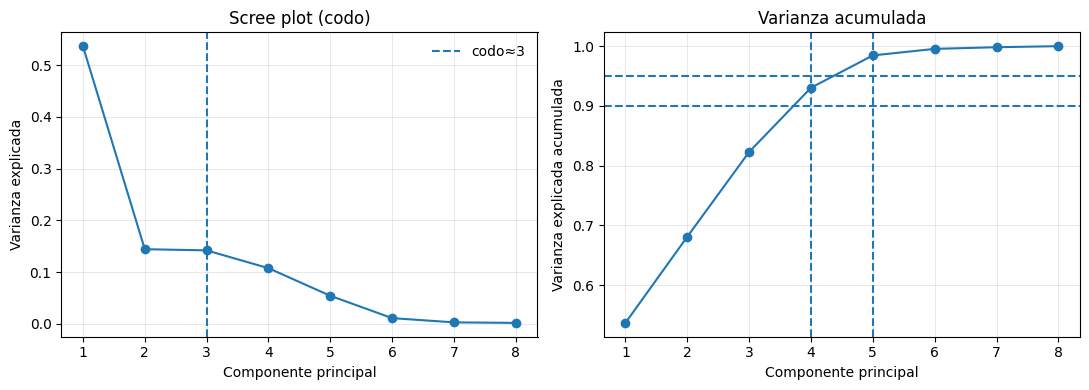

In [16]:
# --------- Gráficos ----------
fig, axs = plt.subplots(1, 2, figsize=(11, 4))

# (a) Scree / codo
axs[0].plot(ks, expl, marker="o")
axs[0].set_xlabel("Componente principal")
axs[0].set_ylabel("Varianza explicada")
axs[0].set_title("Scree plot (codo)")
axs[0].grid(True, linewidth=0.4, alpha=0.5)
axs[0].axvline(k_elbow, linestyle="--", label=f"codo≈{k_elbow}")
axs[0].legend(frameon=False)

# (b) Acumulada con líneas de referencia
axs[1].plot(ks, cum, marker="o")
axs[1].set_xlabel("Componente principal")
axs[1].set_ylabel("Varianza explicada acumulada")
axs[1].set_title("Varianza acumulada")
axs[1].grid(True, linewidth=0.4, alpha=0.5)
axs[1].axhline(0.90, linestyle="--");
axs[1].axvline(k90, linestyle="--")
axs[1].axhline(0.95, linestyle="--");
axs[1].axvline(k95, linestyle="--")

plt.tight_layout();
plt.show()

In [17]:
# Elige el número de componentes (puedes usar 0.95 para varianza acumulada)

###############################################
k = 8
###############################################

pca_pipe = Pipeline(steps=[
    ("pre", preprocessor_num),         # tu preprocesador tal cual
    ("std_for_pca", StandardScaler()), # re-estandarización para usar correlaciones
    ("pca", PCA(n_components=k, svd_solver="full", random_state=0)),

])

# --- FIT en train ---
pca_pipe.fit(X_train_num_reg)

# --- TRANSFORM en train y test ---
T_train = pca_pipe.transform(X_train_num_reg)
T_test  = pca_pipe.transform(X_test_num_reg)

# DataFrames de scores
pc_cols = [f"PC{i+1}" for i in range(T_train.shape[1])]
T_train_df = pd.DataFrame(T_train, columns=pc_cols, index=X_train_num_reg.index)
T_test_df  = pd.DataFrame(T_test,  columns=pc_cols, index=X_test_num_reg.index)

# Varianza explicada
pca_step = pca_pipe.named_steps["pca"]
expl = pca_step.explained_variance_ratio_
print("Varianza explicada:", np.round(expl, 6))
print("Acumulada:", np.round(np.cumsum(expl), 6))

# Guardar outputs (opcional)
T_train_df.to_csv("T_train_PCA.csv", index=False)
T_test_df.to_csv("T_test_PCA.csv", index=False)

print("Shapes -> T_train:", T_train_df.shape, "| T_test:", T_test_df.shape)
display(T_train_df.head())




Varianza explicada: [0.536678 0.144207 0.14195  0.107526 0.054138 0.01097  0.002765 0.001766]
Acumulada: [0.536678 0.680886 0.822835 0.930361 0.984499 0.995469 0.998234 1.      ]
Shapes -> T_train: (75000, 8) | T_test: (25000, 8)


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
2606,2.548766,-0.533196,-1.345833,-1.403101,0.696319,-0.055441,-0.023956,-0.021625
57228,-3.192166,-0.749290,-0.720432,-0.505921,-0.227657,-0.032160,-0.051353,0.008505
8382,-3.599883,-1.030802,-0.038419,-0.212926,-0.192728,-0.034790,-0.052418,0.005928
60281,0.920054,-0.449899,-0.487193,-0.333376,-0.408303,0.208304,-0.007324,-0.020099
48432,1.990848,0.732242,1.051311,0.392595,-0.662599,-0.135006,0.024582,-0.220002


# Representacion en 2D

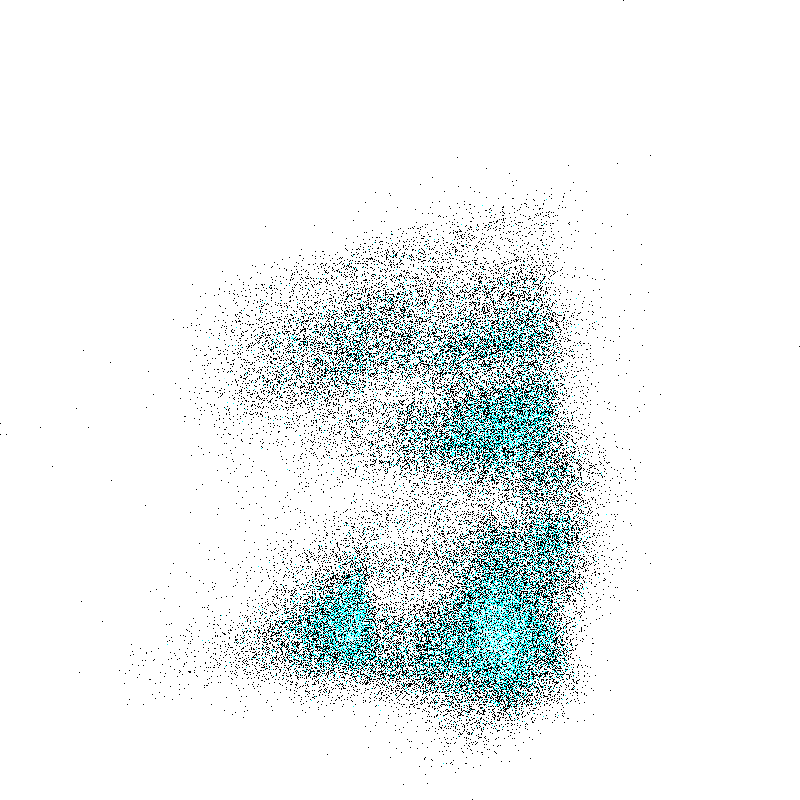

In [18]:
import datashader as ds
import datashader.transfer_functions as tf
from IPython.display import display

df_plot = T_train_df.iloc[:, :3].copy()
df_plot["objetivo"] = y_train_reg.loc[T_train_df.index]

# Canvas
cvs = ds.Canvas(plot_width=800, plot_height=800)

# Aggregate
agg = cvs.points(df_plot, 'PC1', 'PC2', agg=ds.count())

# Shade (convertir agregación en imagen)
img = tf.shade(
    agg,
    cmap=["black", "purple", "cyan", "white"],
    how="eq_hist"
)


display(img.to_pil())

# Representacion en '3D'

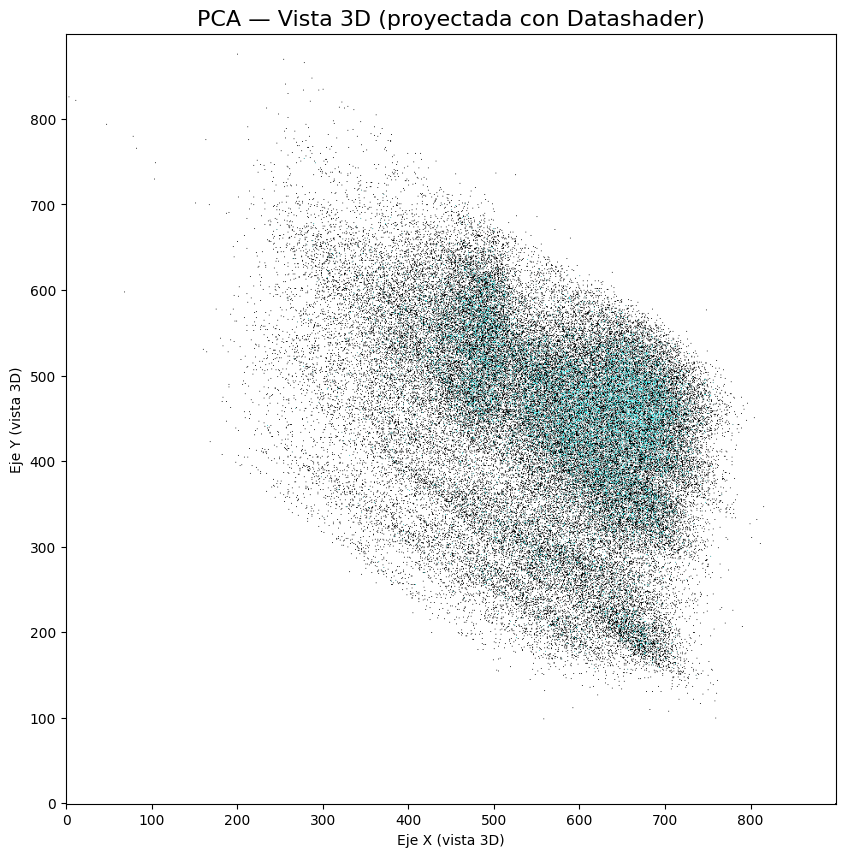

In [24]:
import datashader as ds
import datashader.transfer_functions as tf
import numpy as np
import pandas as pd
from IPython.display import display
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Preparar datos
df_plot = T_train_df.iloc[:, :3].copy()  # PC1, PC2, PC3
df_plot["objetivo"] = y_train_reg.loc[T_train_df.index].astype(int)

# Proyección 3D → 2D (vista 3D)
# Matriz de rotación para una vista tipo (azimuth, elevation)
az = 45   # ángulo horizontal
el = 30   # ángulo vertical

# Convertir ángulos a radianes
az_rad = np.radians(az)
el_rad = np.radians(el)

# Matriz de proyección (estilo cámara)
R = np.array([
    [np.cos(az_rad), -np.sin(az_rad), 0],
    [np.sin(az_rad)*np.sin(el_rad),  np.cos(az_rad)*np.sin(el_rad), -np.cos(el_rad)],
    [np.sin(az_rad)*np.cos(el_rad),  np.cos(az_rad)*np.cos(el_rad),  np.sin(el_rad)]
])

# Aplicar proyección
pts = df_plot[["PC1","PC2","PC3"]].values @ R.T
df_proj = pd.DataFrame(pts[:, :2], columns=["X","Y"])
df_proj["objetivo"] = df_plot["objetivo"]

# Datashader canvas
cvs = ds.Canvas(plot_width=900, plot_height=900)

agg = cvs.points(df_proj, "X", "Y", agg=ds.count())

img = tf.shade(
    agg,
    cmap=["black","purple","cyan","white"],
    how="eq_hist"
).to_pil()

# Mostrar en Matplotlib con título de vista 3D
plt.figure(figsize=(10,10))
plt.imshow(img, origin="lower")
plt.title("PCA — Vista 3D (proyectada con Datashader)", fontsize=16)
plt.xlabel("Eje X (vista 3D)")
plt.ylabel("Eje Y (vista 3D)")
plt.show()


In [26]:
df_train_cat_encode = df_train_cat_encode.reindex(T_train_df.index)
df_test_cat_encode = df_test_cat_encode.reindex(T_test_df.index)

# Concatenar PCs + categóricas (vacías en este caso)
T_train_final = pd.concat([T_train_df, df_train_cat_encode], axis=1)
T_test_final = pd.concat([T_test_df, df_test_cat_encode], axis=1)

# Añadir columna objetivo REAL del modelo de regresión
T_train_final_out = T_train_final.copy()
T_test_final_out = T_test_final.copy()

# Aquí debemos usar y_train_reg y y_test_reg
T_train_final_out["objetivo"] = y_train_reg.loc[T_train_final.index].astype(str)
T_test_final_out["objetivo"] = y_test_reg.loc[T_test_final.index].astype(str)

print("T_train_final:", T_train_final.shape)
print("T_test_final :", T_test_final.shape)

# Exportación
T_train_final.to_csv("T_train_final.csv", index=False)
T_test_final.to_csv("T_test_final.csv", index=False)
T_train_final_out.to_csv("T_train_final_objetivo.csv", index=False)
T_test_final_out.to_csv("T_test_final_objetivo.csv", index=False)


T_train_final: (75000, 8)
T_test_final : (25000, 8)


In [27]:
T_train_final_out.head(10)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,objetivo
2606,2.548766,-0.533196,-1.345833,-1.403101,0.696319,-0.055441,-0.023956,-0.021625,0.5940167
57228,-3.192166,-0.749290,-0.720432,-0.505921,-0.227657,-0.032160,-0.051353,0.008505,0.0720139
8382,-3.599883,-1.030802,-0.038419,-0.212926,-0.192728,-0.034790,-0.052418,0.005928,0.09519737
60281,0.920054,-0.449899,-0.487193,-0.333376,-0.408303,0.208304,-0.007324,-0.020099,0.5473541
48432,1.990848,0.732242,1.051311,0.392595,-0.662599,-0.135006,0.024582,-0.220002,1.245754
2510,-2.185725,1.647859,0.739267,-0.919599,0.169827,0.016181,0.037863,0.007011,-4.396029e-05
29712,1.746619,0.335521,1.034523,-1.407812,0.509396,-0.561701,0.089914,0.629344,1.013433
68162,0.775974,0.987111,0.429320,-0.691120,-0.735772,-0.105016,0.035582,-0.052203,0.9288485
60530,0.248888,-0.938279,0.780306,-0.364646,-0.303392,0.356418,0.136090,-0.007025,0.4858752
46682,1.148567,0.438849,0.464530,1.928595,-0.285420,-0.033015,-0.017754,0.060986,1.809125


In [29]:
# === Guardar artefactos ===
import joblib
import json

# 1) Pipelines ya FIT: preprocessor_cat y pca_pipe
#joblib.dump(preprocessor_cat, "preprocessor_cat.joblib")
joblib.dump(pca_pipe, "pca_pipe_num.joblib")  # (preprocessor_num + StdScaler + PCA)

# 2) Metadatos útiles para producción
meta = {
    "cols_num": cols_num,  # columnas numéricas originales
    #"cols_cat": cols_cat,   columnas categóricas originales
    "pc_cols": list(T_train_df.columns),  # nombres de PCs (PC1, PC2, …)
    "cat_out_cols": list(df_train_cat_encode.columns)  # columnas codificadas finales (OHE + Ordinal)
}
with open("pca_metadata.json", "w") as f:
    json.dump(meta, f, ensure_ascii=False, indent=2)

In [30]:
import os, zipfile, glob

# Guardamos los calculos y el proceso de los calculos
# Carpeta destino en tu PC
dst_dir = r"mi_pca"
os.makedirs(dst_dir, exist_ok=True)
zip_path = os.path.join(dst_dir, "pca_artifacts_bundle.zip")

# Archivos que quieres incluir (ajusta si te falta alguno)
candidates = [
    "T_test_PCA.csv",
    "T_test_final.csv",
    "T_test_final_objetivo.csv",
    "T_train_PCA.csv",
    "T_train_final.csv",
    "T_train_final_objetivo.csv",
    "boxplots_numericas.png",
    "histogramas_numericas.png",
    "pca_metadata.json",
    "pca_pipe_num.joblib",
    "preprocessor_cat.joblib",
]

present = [f for f in candidates if os.path.exists(f)]
# Si quieres incluir una carpeta (p. ej., 'sample_data'), descomenta:
# for root, _, files in os.walk("sample_data"):
#     for f in files:
#         present.append(os.path.join(root, f))

with zipfile.ZipFile(zip_path, "w", compression=zipfile.ZIP_DEFLATED) as zf:
    for f in present:
        zf.write(f, arcname=os.path.basename(f))  # guarda sin subcarpetas

print("ZIP creado en:", zip_path)
print("Incluidos:", present)

ZIP creado en: mi_pca\pca_artifacts_bundle.zip
Incluidos: ['T_test_PCA.csv', 'T_test_final.csv', 'T_test_final_objetivo.csv', 'T_train_PCA.csv', 'T_train_final.csv', 'T_train_final_objetivo.csv', 'pca_metadata.json', 'pca_pipe_num.joblib']
